# Estimating Covariance

In [1]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

In [2]:
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth', 'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper', 'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
ind_rets = erk.get_ind_returns(weighting='ew', n_inds=49)['1974':]
ind_mcap = erk.get_ind_market_caps(n_inds=49, weights=True)['1974':]

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.133872,0.187733,-0.613456,6.736417,0.082009,0.122226,0.538298,-0.59806
CW,0.133744,0.187514,-0.542993,5.793708,0.081947,0.120151,0.538266,-0.58785


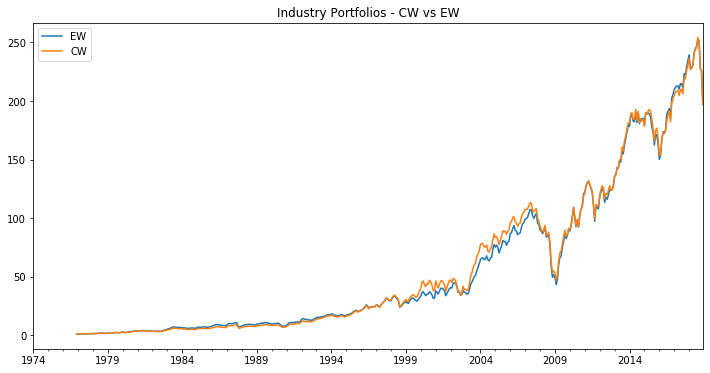

In [3]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights = ind_mcap)
btr = pd.DataFrame({
    'EW': ewr,
    'CW': cwr
})
(1+btr).cumprod().plot(figsize=(12, 6), title='Industry Portfolios - CW vs EW')
erk.summary_stats(btr.dropna())

## Building the Global Minimum Variance Portfolio

In [4]:
def sample_cov(r, **kwargs):
    '''
    Returns the sample covariance of the supplied returns
    '''
    return r.cov()


def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    '''
    Produces the weights of the GMV portfolio given a covariance matrix of the returns
    '''
    est_cov = cov_estimator(r, **kwargs)
    return erk.gmv(est_cov)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.133872,0.187733,-0.613456,6.736417,0.082009,0.122226,0.538298,-0.598060
CW,0.133744,0.187514,-0.542993,5.793708,0.081947,0.120151,0.538266,-0.587850
GMV-Sample,0.159492,0.097031,-0.530814,5.054806,0.036142,0.055959,1.298908,-0.332077


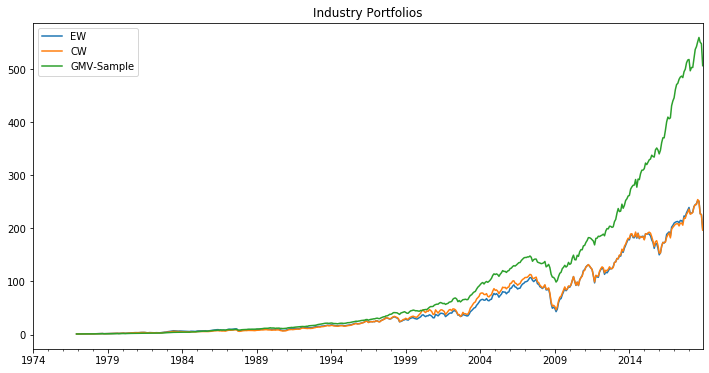

In [6]:
mv_s_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
btr = pd.DataFrame({
    'EW': ewr,
    'CW': cwr,
    'GMV-Sample': mv_s_r
})
(1+btr).cumprod().plot(figsize=(12, 6), title='Industry Portfolios')
erk.summary_stats(btr.dropna())

Using the constant covariance estimator for the global minimum variance portfolio.

In [7]:
def cc_cov(r, **kwargs):
    '''
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    '''
    rhos = r.corr()
    n = rhos.shape[0]
    # rhos is a symmetric matrix with diagonals all 1, so mean correlation is:
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

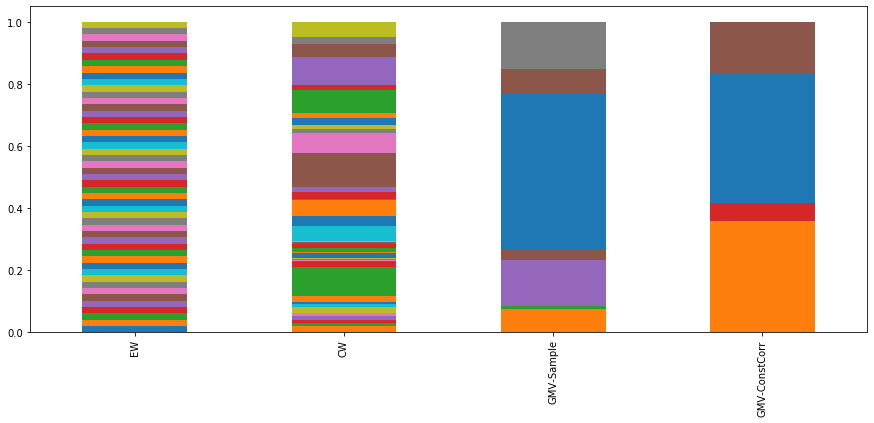

In [9]:
wts = pd.DataFrame({
    'EW': erk.weight_ew(ind_rets['2016':]),
    'CW': erk.weight_cw(ind_rets['2016':], cap_weights=ind_mcap),
    'GMV-Sample': weight_gmv(ind_rets['2016':], cov_estimator=sample_cov),
    'GMV-ConstCorr': weight_gmv(ind_rets['2016':], cov_estimator=cc_cov)
})
wts.T.plot.bar(stacked=True, figsize=(15, 6), legend=False)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.133872,0.187733,-0.613456,6.736417,0.082009,0.122226,0.538298,-0.598060
CW,0.133744,0.187514,-0.542993,5.793708,0.081947,0.120151,0.538266,-0.587850
GMV-Sample,0.159492,0.097031,-0.530814,5.054806,0.036142,0.055959,1.298908,-0.332077
GMV-CC,0.141792,0.102668,-0.500390,4.458301,0.040353,0.061777,1.059742,-0.421370


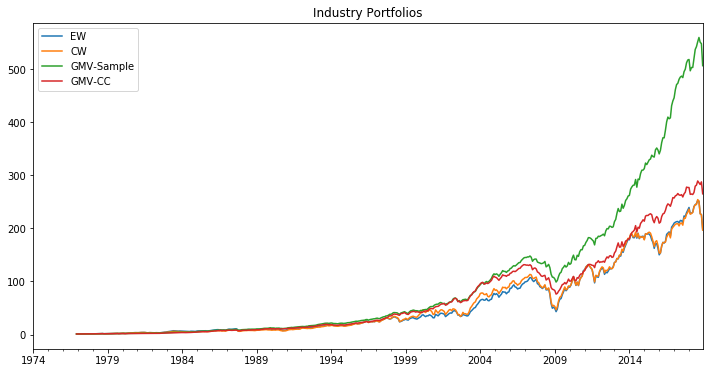

In [11]:
mv_cc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=cc_cov)
btr = pd.DataFrame({
    'EW': ewr,
    'CW': cwr,
    'GMV-Sample': mv_s_r,
    'GMV-CC': mv_cc_r
})
(1+btr).cumprod().plot(figsize=(12, 6), title='Industry Portfolios')
erk.summary_stats(btr.dropna())

## Statistical Shrinkage
We can mix the model and sample estimates by choosing a shrinkage parameter. You can either let the numbers dictate optimal shrinkage value for $\delta\$ although in practice we can choose 0.5. Implement a simple shrinkage based covariance estimator that shrinks towards the constant correlation estimate.

In [12]:
def shrinkage_cov(r, delta=0.5, **kwargs):
    '''
    Covariance estimator that shrinks between the sample covariance and the constant correlation estimators
    '''
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

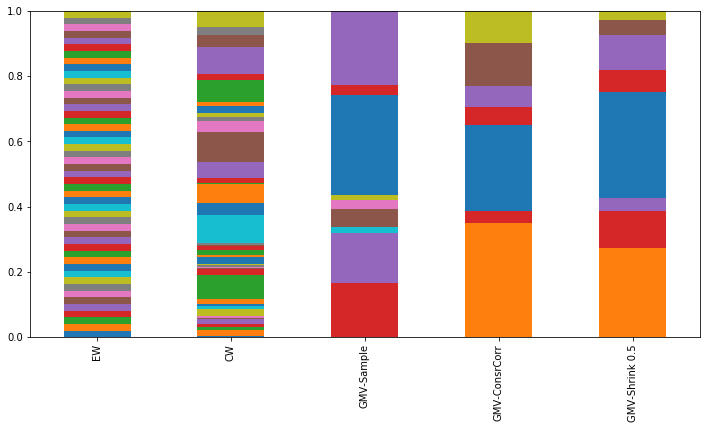

In [13]:
wts = pd.DataFrame({
    'EW': erk.weight_ew(ind_rets['2013':]),
    'CW': erk.weight_cw(ind_rets['2013':], cap_weights=ind_mcap),
    'GMV-Sample': weight_gmv(ind_rets['2013':], cov_estimator=sample_cov),
    'GMV-ConsrCorr': weight_gmv(ind_rets['2013':], cov_estimator=cc_cov),
    'GMV-Shrink 0.5': weight_gmv(ind_rets['2013':], cov_estimator=shrinkage_cov)
})
wts.T.plot.bar(stacked=True, figsize=(12, 6), legend=False)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.133872,0.187733,-0.613456,6.736417,0.082009,0.122226,0.538298,-0.598060
CW,0.133744,0.187514,-0.542993,5.793708,0.081947,0.120151,0.538266,-0.587850
GMV-Sample,0.159492,0.097031,-0.530814,5.054806,0.036142,0.055959,1.298908,-0.332077
GMV-CC,0.141792,0.102668,-0.500390,4.458301,0.040353,0.061777,1.059742,-0.421370
GMV-Shrink 0.5,0.147691,0.099441,-0.525147,4.718844,0.038352,0.059434,1.151897,-0.409058


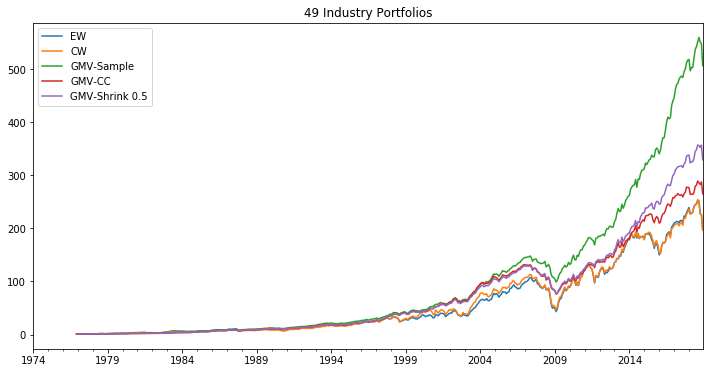

In [15]:
mv_sh_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.5)
btr = pd.DataFrame({
    'EW': ewr,
    'CW': cwr,
    'GMV-Sample': mv_s_r,
    'GMV-CC': mv_cc_r,
    'GMV-Shrink 0.5': mv_sh_r
})
(1+btr).cumprod().plot(figsize=(12, 6), title='49 Industry Portfolios')
erk.summary_stats(btr.dropna())